# Brain tumor 3D segmentation with MONAI

This tutorial shows how to integrate MONAI into an existing PyTorch medical DL program.

And easily use below features:
1. Transforms for dictionary format data.
1. Load MHA image with metadata.
1. Add channel dim to the data if no channel dimension.
1. Scale medical image intensity with normalized range.
1. Crop out a batch of balanced images based on positive / negative label ratio.
1. Cache IO and transforms to accelerate training and validation.
1. 3D UNet model, Dice loss function, Mean Dice metric for 3D segmentation task.
1. Sliding window inference method.
1. Deterministic training for reproducibility.

The brain tumor dataset can be downloaded from https://www.kaggle.com/andrewmvd/brain-tumor-segmentation-in-mri-brats-2015/.

![Brain](https://www.med.upenn.edu/cbica/assets/user-content/images/BraTS/BRATS_banner_noCaption.png)

Target: Brain tumor
Modality: MRI
MRI Type : T1, T1 injected, T2, T2 FLAIR
Size: 1092 3D volumes
Source: Perelman School of Medicine

## Setup environment

In [25]:
!python -c "import monai" || pip install -q "monai[gdown, nibabel, tqdm, itk]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import sklearn" || pip install -q scikit-learn
%matplotlib inline

In [26]:
from monai.apps import download_url, extractall
from monai.utils import first, set_determinism
from monai.transforms import (AsDiscrete, AddChanneld, Compose, CropForegroundd, LoadImaged,
                              Orientationd, RandCropByPosNegLabeld, Spacingd, ToTensord,
                              ScaleIntensityd, MapTransform)
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import compute_meandice
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset
from monai.config import print_config
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report, confusion_matrix, )

## Setup imports

In [27]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


print_config()

MONAI version: 0.5.3
Numpy version: 1.19.2
Pytorch version: 1.7.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: d78c669c67e38ddfbe572f6a0438e9df0b8c65d7

Optional dependencies:
Pytorch Ignite version: 0.4.4
Nibabel version: 3.2.1
scikit-image version: 0.18.1
Pillow version: 8.1.0
Tensorboard version: 2.4.1
gdown version: 3.12.2
TorchVision version: 0.8.2
ITK version: 5.1.2
tqdm version: 4.56.0
lmdb version: 1.0.0
psutil version: 5.8.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

In [28]:
root_dir = "./"
data_dir = os.path.join(root_dir, "data")
res_dir = os.path.join(root_dir, "results")
os.makedirs(res_dir, exist_ok=True)
trained_model_path = os.path.join(res_dir, "net_key_metric=0.7314.pt")

## Download data if necessary

In [ ]:
if not os.path.exists(trained_model_path):
    resource = "https://github.com/Thibault-Pelletier/MonaiWorkshop/blob/e29cdaa46e0097db909478e95c001d303ae963ab/results/net_key_metric=0.7314.pt"
    download_url(url=resource, filepath=trained_model_path)

# resource = "https://drive.google.com/uc?id=1aMc9eW_fGCphGBjAKDedxu8-aJVcSczd"  # Full 2.9 GB dataset
resource = "https://drive.google.com/uc?id=1rZwPR3CFlFmYTev2YkxTJDfmLrbCiy63"  # Small 200 MB dataset subset

compressed_file = os.path.join(root_dir, "brats2015 - data.zip")
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    download_url(url=resource, filepath=compressed_file)
    extractall(filepath=compressed_file, output_dir=data_dir)

## Set dataset path

In [29]:
train_dirs = [os.path.join(data_dir, "train", "HGG"), os.path.join(data_dir, "train", "LGG")]
test_dir = os.path.join(data_dir, "test", "HGG_LGG")

data_dicts = []
for train_dir in train_dirs:
    test_folders = os.listdir(train_dir)

    for test_folder in test_folders:
        test_folder_path = os.path.join(train_dir, test_folder)
        data_files = os.listdir(test_folder_path)
        mri_files = [f for f in data_files if "more" not in f]
        if len(mri_files) == len(data_files):
            continue

        label_file = [f for f in data_files if "more" in f][0]

        data_dicts.extend(
            [{"image": os.path.join(test_folder_path, mri_file), "label": os.path.join(test_folder_path, label_file)}
             for mri_file in mri_files])

print("Number of training data : ", len(data_dicts))
valid_split = 0.3
valid_n = int(valid_split * len(data_dicts))
# train_files, val_files = data_dicts[:-valid_n], data_dicts[-valid_n:]
train_files, val_files = data_dicts[:100], data_dicts[-30:]

Number of training data :  1092


## Set deterministic training for reproducibility

In [30]:
set_determinism(seed=0)

## Create custom transform for labels

In [31]:
class FixLabelAffineAndReduceClassesToOne(MapTransform):
    """
    Custom transform to fixe saved label affine transform if necessary (value may not be aligned with the input image)
    """

    def __init__(self, keys):
        super().__init__(keys)

    def __call__(self, data):
        d = dict(data)
        image_affine = d[f"image_meta_dict"]["affine"]

        try:
            meta_data = d[f"label_meta_dict"]
            label_affine = meta_data["affine"]
            if np.array_equal(label_affine, np.identity(4)):
                meta_data["affine"] = image_affine

        except KeyError:
            pass

        # Saturate label values greater than 1 to 1
        label_values = d["label"]
        d["label"] = (label_values > 0).astype(label_values.dtype)
        return d

## Setup transforms for training and validation

Here we use several transforms to augment the dataset:
1. `LoadImaged` loads the spleen MRI images and labels from MHA format files.
1. `FixLabelAffineAndReduceClassesToOne` Fixes label affine transform if necessary and saturates the output of the labels above 1 to 1
1. `AddChanneld` as the original data doesn't have channel dim, add 1 dim to construct "channel first" shape.
1. `Spacingd` adjusts the spacing by `pixdim=(1, 1, 1)` based on the affine matrix.
1. `Orientationd` unifies the data orientation based on the affine matrix.
1. `ScaleIntensityd` normalises intensities between [0, 1].
1. `CropForegroundd` removes all zero borders to focus on the valid body area of the images and labels.
1. `RandCropByPosNegLabeld` randomly crop patch samples from big image based on pos / neg ratio.  
The image centers of negative samples must be in valid body area.
1. `ToTensord` converts the numpy array to PyTorch Tensor for further steps.

In [32]:
train_transforms = Compose([LoadImaged(keys=["image", "label"]),  #
                            FixLabelAffineAndReduceClassesToOne(keys=["image", "label"]),  #
                            AddChanneld(keys=["image", "label"]),  #
                            Spacingd(keys=["image", "label"], pixdim=(1, 1, 1), mode=("bilinear", "nearest")),  #
                            Orientationd(keys=["image", "label"], axcodes="RAS"),  #
                            ScaleIntensityd(keys=["image"]),  #
                            CropForegroundd(keys=["image", "label"], source_key="image"),  #
                            RandCropByPosNegLabeld(keys=["image", "label"], label_key="label",  #
                                                   spatial_size=(96, 96, 96), pos=1, neg=1, num_samples=4,  #
                                                   image_key="image", image_threshold=0, ),  #
                            ToTensord(keys=["image", "label"]),  #
                            ])

val_transforms = Compose([LoadImaged(keys=["image", "label"]),  #
                          FixLabelAffineAndReduceClassesToOne(keys=["image", "label"]),  #
                          AddChanneld(keys=["image", "label"]),  #
                          Spacingd(keys=["image", "label"], pixdim=(1, 1, 1), mode=("bilinear", "nearest")),  #
                          Orientationd(keys=["image", "label"], axcodes="RAS"),  #
                          ScaleIntensityd(keys=["image"]),  #
                          CropForegroundd(keys=["image", "label"], source_key="image"),  #
                          ToTensord(keys=["image", "label"]),  #
                          ])

## Check transforms in DataLoader

image shape: torch.Size([135, 163, 137]), label shape: torch.Size([135, 163, 137])


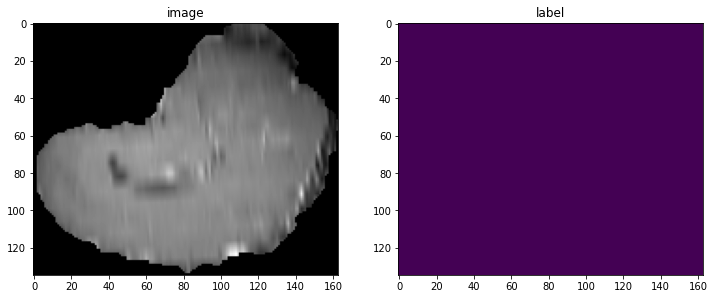

In [33]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 50]
i_slice = 50
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, i_slice], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, i_slice])
plt.show()

## Define CacheDataset and DataLoader for training and validation

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to try the regular Dataset, just change to use the commented code below.

In [34]:
# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_ds = CacheDataset(data=train_files, transform=train_transforms, num_workers=0)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True)

val_ds = CacheDataset(data=val_files, transform=val_transforms, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=1)


Loading dataset: 100%|██████████| 30/30 [00:07<00:00,  3.80it/s]


## Create Model, Loss, Optimizer

In [35]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNet(dimensions=3,  #
             in_channels=1,  #
             out_channels=1,  #
             channels=(16, 32, 64, 128, 256),  #
             strides=(2, 2, 2, 2),  #
             num_res_units=2, norm=Norm.BATCH, ).to(device)  #

loss_function = DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

## Execute a typical PyTorch training process

In [36]:
max_epochs = 10
# max_epochs = 300
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = AsDiscrete(threshold_values=True, n_classes=1)
post_label = AsDiscrete(n_classes=1)

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (batch_data["image"].to(device), batch_data["label"].to(device),)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, "
              f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            metric_sum = 0.0
            metric_count = 0
            for val_data in val_loader:
                val_inputs, val_labels = (val_data["image"].to(device), val_data["label"].to(device),)
                roi_size = (96, 96, 96)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = post_pred(val_outputs)
                val_labels = post_label(val_labels)
                value = compute_meandice(y_pred=val_outputs, y=val_labels, include_background=False, )
                metric_count += len(value)
                metric_sum += value.sum().item()
            metric = metric_sum / metric_count
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(res_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                  f"\nbest mean dice: {best_metric:.4f} "
                  f"at epoch: {best_metric_epoch}")

----------
epoch 1/50
1/50, train_loss: 0.6877
2/50, train_loss: 0.7836
3/50, train_loss: 0.8984
4/50, train_loss: 0.7244
5/50, train_loss: 0.6869
6/50, train_loss: 0.6750
7/50, train_loss: 0.8301
8/50, train_loss: 0.6984
9/50, train_loss: 0.6089
10/50, train_loss: 0.8281
11/50, train_loss: 0.7488
12/50, train_loss: 0.6518
13/50, train_loss: 0.8442
14/50, train_loss: 0.8608
15/50, train_loss: 0.8859
16/50, train_loss: 0.7442
17/50, train_loss: 0.8103
18/50, train_loss: 0.7815
19/50, train_loss: 0.8090
20/50, train_loss: 0.7879
21/50, train_loss: 0.7135
22/50, train_loss: 0.7241
23/50, train_loss: 0.6860
24/50, train_loss: 0.5917
25/50, train_loss: 0.7165
26/50, train_loss: 0.7004
27/50, train_loss: 0.6735
28/50, train_loss: 0.8056
29/50, train_loss: 0.7086
30/50, train_loss: 0.7084
31/50, train_loss: 0.7964
32/50, train_loss: 0.8526
33/50, train_loss: 0.6844
34/50, train_loss: 0.6659
35/50, train_loss: 0.5548
36/50, train_loss: 0.6674
37/50, train_loss: 0.7290
38/50, train_loss: 0.8151

In [37]:
print(f"train completed, best_metric: {best_metric:.4f} "
      f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.1924 at epoch: 26


## Plot the loss and metric

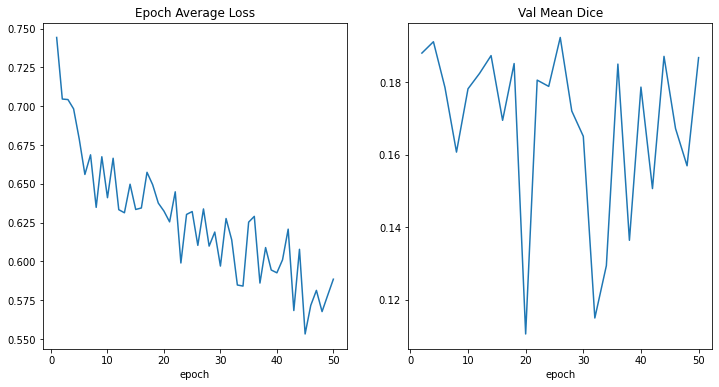

In [38]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

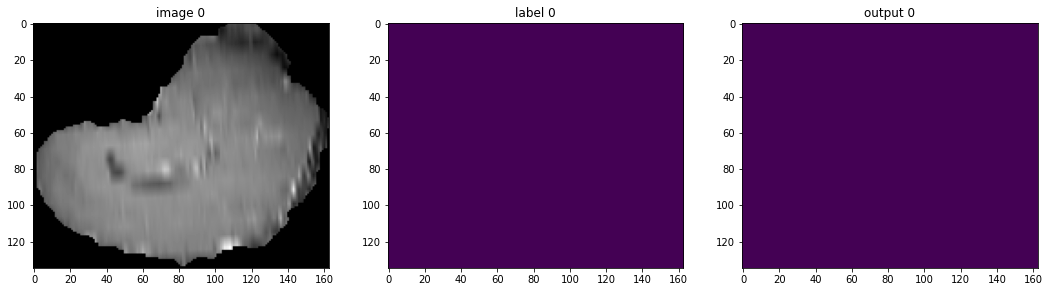

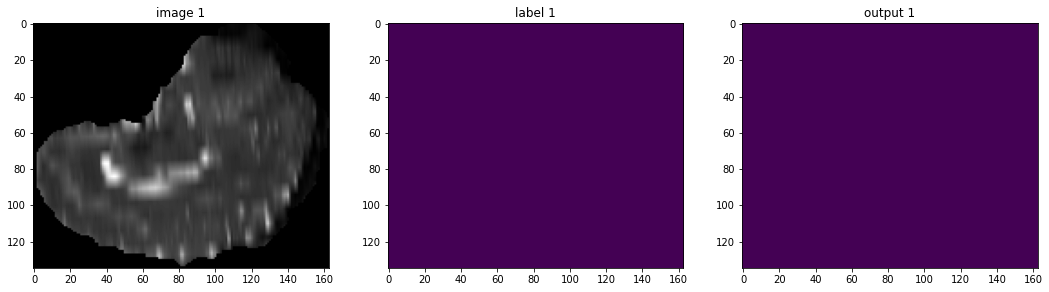

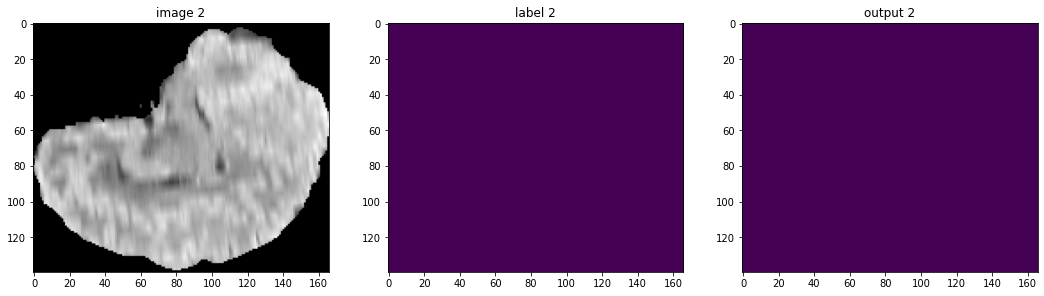

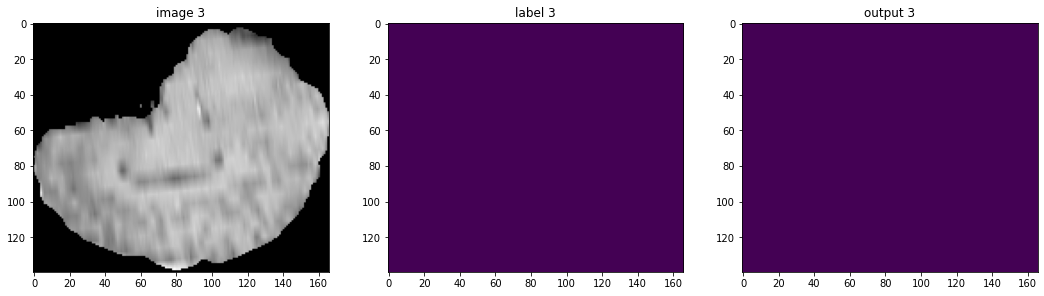

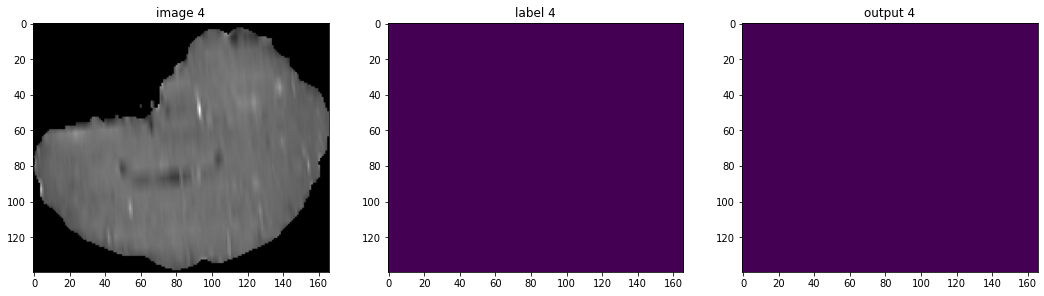

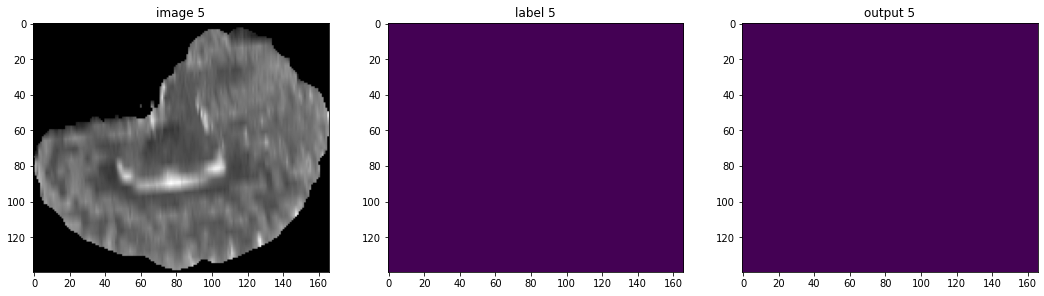

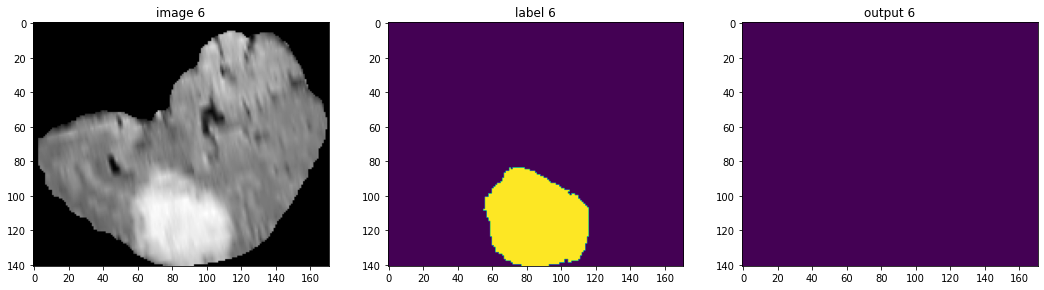

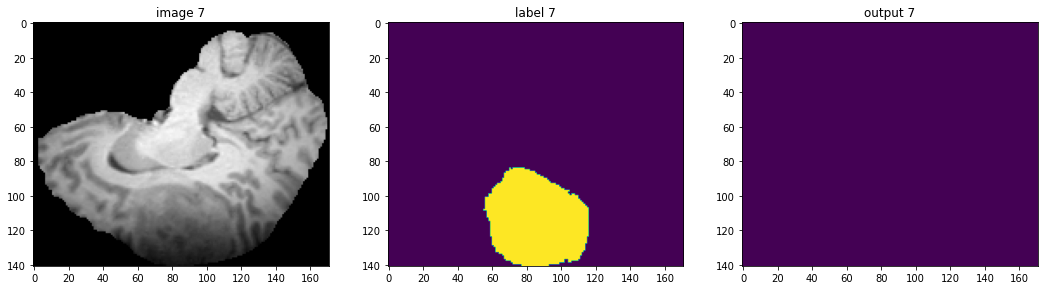

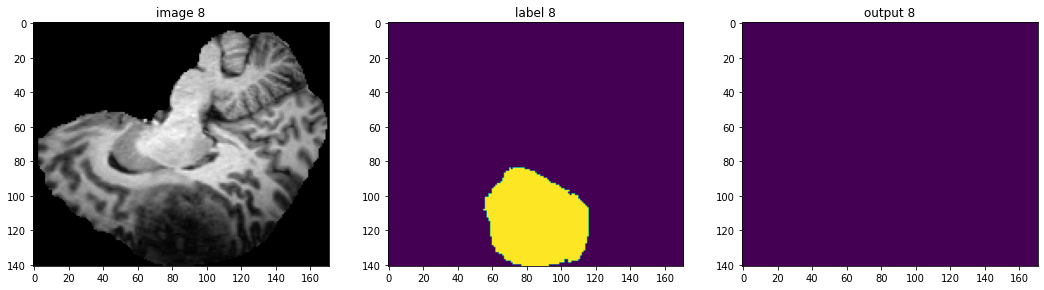

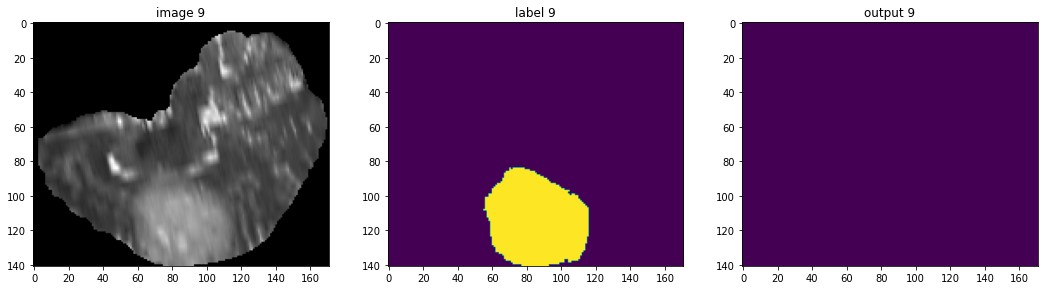

In [39]:
# model.load_state_dict(torch.load(os.path.join(res_dir, "best_metric_model.pth")))
model.load_state_dict(torch.load(trained_model_path))
model.eval()

with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        if i >= 10:
            break

        roi_size = (96, 96, 96)
        sw_batch_size = 4
        val_outputs = post_pred(sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model))

        # plot the slice [:, :, 50]
        i_slice = 50
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, i_slice], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, i_slice])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(val_outputs.cpu().numpy()[0, 0, :, :, i_slice])
        plt.show()

## Check the confusion matrix on the validation data

              precision    recall  f1-score   support

   non-tumor       0.99      0.77      0.87  31189788
       tumor       0.10      0.83      0.17    894826

    accuracy                           0.77  32084614
   macro avg       0.54      0.80      0.52  32084614
weighted avg       0.97      0.77      0.85  32084614



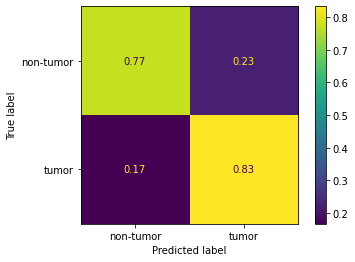

In [40]:
cpu_device = torch.device("cpu")
y_pred = torch.tensor([], dtype=torch.float32, device=cpu_device)
y = torch.tensor([], dtype=torch.long, device=cpu_device)

with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        if i >= 10:
            break

        roi_size = (96, 96, 96)

        sw_batch_size = 4
        outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)
        outputs = post_pred(outputs).cpu()
        labels = val_data["label"].cpu()

        y_pred = torch.cat([y_pred, outputs.flatten()], dim=0)
        y = torch.cat([y, labels.flatten()], dim=0)


print(classification_report(y.numpy(), y_pred.numpy(), target_names=["non-tumor", "tumor"]))

cm = confusion_matrix(y.numpy(), y_pred.numpy(), normalize="true", )
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["non-tumor", "tumor"], )
disp.plot(ax=plt.subplots(1, 1, facecolor="white")[1])
plt.show()